In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [17]:
def correct_incorrect_losses(df):
    losses = df['reconstruction_losses'].values
    correct_indices = (df['predictions'] == df['labels'])
    correctly_classified_losses = losses[correct_indices]
    incorrectly_classified_losses = losses[np.invert(correct_indices)]
    return correctly_classified_losses, incorrectly_classified_losses

In [16]:
def histogram(arr, title=""):
    plt.hist(arr, bins=30)
    plt.title(title)
    plt.show()
    return

def overlapping_histograms(arrs, labels, title=""):
    plt.hist(arrs, label=labels, density=True, bins=30)
    plt.title(title)
    plt.legend()
    plt.show()
    return

In [15]:
def display_no_patch_recon_distributions(df):
    test = df[df['scales'] == 0]
    correct_losses, incorrect_losses = correct_incorrect_losses(test)
    critical_90 = np.percentile(correct_losses, 90)
    #print("90th percentile of Correctly Classified Reconstruction Loss: " + str(critical_90))
    critical_95 = np.percentile(correct_losses, 95)
    print("95th percentile of Correctly Classified Reconstruction Loss: " + str(critical_95))
    critical_99 = np.percentile(correct_losses, 99)
    #print("99th percentile of Correctly Classified Reconstruction Loss: " + str(critical_99))
    log_cl, log_icl = np.log(correct_losses), np.log(incorrect_losses)
    #overlapping_histograms([correct_losses,incorrect_losses], ["correct", "incorrect"], "Density of Correct and Incorrect Losses")
    overlapping_histograms([log_cl, log_icl], ["correct", "incorrect"], "Density of Log Correct and Log Incorrect Losses")
    return critical_90, critical_95, critical_99

In [14]:
def rates_by_scales(df, target_class:int, det_thres:float):
    def fooled_rate(data):
        # P(fooled)
        fooled = (data['predictions'] == target_class)
        num_fooled = np.count_nonzero(fooled)
        return num_fooled / len(fooled)
    def detection_rate(data):
        # P(detected)
        detected = (data['reconstruction_losses'] > det_thres)
        num_detected = np.count_nonzero(detected)
        return num_detected / len(detected)
    def success_rate(data):
        # P(fooled & undetected)
        fooled = (data['predictions'] == target_class)
        undetected = (data['reconstruction_losses'] < det_thres)
        successful = fooled & undetected
        return np.count_nonzero(successful) / len(successful)
    filtered = df[df['labels'] != target_class]
    fooled_rates = filtered.groupby('scales').apply(fooled_rate)
    detection_rates = filtered.groupby('scales').apply(detection_rate)
    success_rates = filtered.groupby('scales').apply(success_rate)
    return fooled_rates, detection_rates, success_rates
    

def display_scaled_patch_success_detection_rates(df, target_class:int, det_thres:float, title="", pdfout=None):
    fooled_rates, detection_rates, success_rates = rates_by_scales(df, target_class, det_thres)
    scales = fooled_rates.index
    plt.plot(scales, detection_rates, '-o', label="ADR")
    plt.plot(scales, fooled_rates, '-o', label="AFR")
    plt.plot(scales, success_rates, '-o', label="ASR")
    #plt.plot(scales, f_detection_rates, '-o', label="AFPR")
    plt.xlabel("Patch Scale")
    plt.legend(loc='upper left')
    plt.xticks(np.arange(0, 1, 0.1))
    plt.title(title)
    if pdfout:
        plt.savefig(pdfout)
    plt.show()


def display_scaled_recon_distributions(df, target_class:int):
    def plot_distribution(data):
        scale = data.scales.values[0]
        correct_losses, incorrect_losses = correct_incorrect_losses(data)
        #log_cl, log_icl = np.log(correct_losses), np.log(incorrect_losses)
        overlapping_histograms([correct_losses,incorrect_losses], ["correct", "incorrect"], "Density of Correct and Incorrect Losses, Patch Scaled by " + str(scale))
        #overlapping_histograms([log_cl, log_icl], ["correct", "incorrect"], "Density of Log Correct and Log Incorrect Losses, Patch Scaled by " + str(scale))
        return 0
    filtered = df[df['labels'] != target_class]
    filtered.groupby('scales').apply(plot_distribution)

In [6]:
import os
import re
def patches_into_table(data_dir, threshold, scale_out_of_ten=3, target_class=0):
    regex = re.compile('\S*png_test.csv')
    patch_success_rates = {}
    total = 0
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if regex.match(file):
                total += 1
                path = os.path.join(data_dir, file)
                fooled_rates, detection_rates, success_rates = rates_by_scales(pd.read_csv(path), target_class, threshold)
                fooled_rate = fooled_rates.values[scale_out_of_ten]
                success_rate = success_rates.values[scale_out_of_ten]
                detection_rate = detection_rates.values[scale_out_of_ten]
                patch_success_rates[file] = (success_rate, fooled_rate, detection_rate)
    patches_sorted_by_success = sorted(patch_success_rates.items(), key=lambda item:item[1][0])
    patches = pd.DataFrame(patches_sorted_by_success, columns=['File', 'Rates'])
    patches['Success'] = patches['Rates'].apply(lambda item:item[0])
    patches['Fooled'] = patches['Rates'].apply(lambda item:item[1])
    patches['Detected'] = patches['Rates'].apply(lambda item:item[2])
    patches['Decreased_Adv_Effectiveness_By'] = 1 - (patches['Success']/patches['Fooled'])
    pd.set_option('display.max_rows', total)
    df = patches[['File', 'Detected', 'Fooled', 'Success', 'Decreased_Adv_Effectiveness_By']]
    print(df.to_latex())

In [7]:
def visualize_patches_results(data_dir, regex, scale_out_of_ten):
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if regex.match(file):
                recon_loss_dataset = os.path.join(patches_dir, file)
                break
        break
    recon_losses = pd.read_csv(recon_loss_dataset)
    crit_90, crit_95, crit_99 = display_no_patch_recon_distributions(recon_losses)
    #print("\nFPR = 10%")
    #patches_into_table(patches_dir, crit_90, scale_out_of_ten)
    print("\nFPR = 5%")
    patches_into_table(patches_dir, crit_95, scale_out_of_ten)
    #print("\nFPR = 1%")
    #patches_into_table(patches_dir, crit_99, scale_out_of_ten)

In [8]:
scale = 4

95th percentile of Correctly Classified Reconstruction Loss: 0.042121217499999995


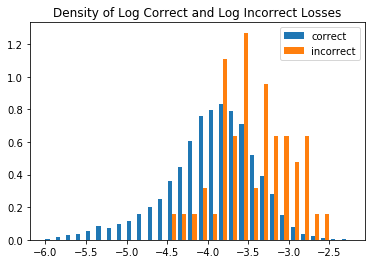


FPR = 5%
\begin{tabular}{llrrrr}
\toprule
{} &                                               File &  Detected &    Fooled &   Success &  Decreased\_Adv\_Effectiveness\_By \\
\midrule
0  &  logs\_mnist\_cnn\_adv\_ten\_20200527\_18\_31\_49\_48911... &  0.158829 &  0.001109 &  0.000776 &                        0.300000 \\
1  &  logs\_mnist\_cnn\_adv\_00\_20200527\_16\_34\_47\_996346... &  0.180235 &  0.002551 &  0.000887 &                        0.652174 \\
2  &  logs\_mnist\_cnn\_adv\_40\_20200527\_16\_36\_32\_555527... &  0.166260 &  0.001442 &  0.000887 &                        0.384615 \\
3  &  logs\_mnist\_cnn\_adv\_25\_20200527\_16\_36\_01\_629416... &  0.190772 &  0.001775 &  0.000998 &                        0.437500 \\
4  &  logs\_mnist\_cnn\_adv\_10\_20200527\_16\_34\_47\_997005... &  0.194099 &  0.001664 &  0.000998 &                        0.400000 \\
5  &  logs\_mnist\_cnn\_adv\_05\_20200527\_16\_34\_47\_994302... &  0.167258 &  0.002329 &  0.001331 &                        

In [9]:
# MNIST CNN
patches_dir = "logs/mnist/cnn_low_lr/20200507_14:21:23:955910_/test"
regex = re.compile('\S*png_test.csv')
scale_out_of_ten = scale
visualize_patches_results(patches_dir, regex, scale_out_of_ten)

95th percentile of Correctly Classified Reconstruction Loss: 0.01913655625


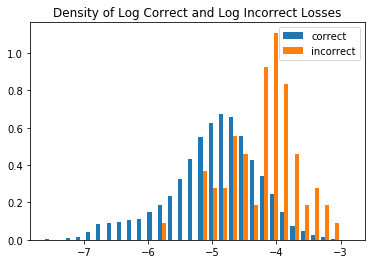


FPR = 5%
\begin{tabular}{llrrrr}
\toprule
{} &                                               File &  Detected &    Fooled &   Success &  Decreased\_Adv\_Effectiveness\_By \\
\midrule
0  &  logs\_mnist\_nomodcap\_adv\_hun\_20200613\_18\_35\_13\_... &  0.423431 &  0.006996 &  0.000777 &                        0.888889 \\
1  &  logs\_mnist\_nomodcap\_adv\_tho\_20200613\_18\_35\_13\_... &  0.429539 &  0.007218 &  0.000888 &                        0.876923 \\
2  &  logs\_mnist\_nomodcap\_adv\_tnk\_20200613\_18\_35\_13\_... &  0.423987 &  0.007218 &  0.001110 &                        0.846154 \\
3  &  logs\_mnist\_nomodcap\_adv\_50\_20200613\_18\_19\_45\_6... &  0.429872 &  0.007885 &  0.001110 &                        0.859155 \\
4  &  logs\_mnist\_nomodcap\_adv\_ten\_20200613\_18\_35\_13\_... &  0.420988 &  0.005886 &  0.001333 &                        0.773585 \\
5  &  logs\_mnist\_nomodcap\_adv\_35\_20200613\_17\_57\_52\_3... &  0.446086 &  0.008440 &  0.001333 &                        

In [10]:
# MNIST NomodCap
patches_dir = "logs/mnist/nomod_cap/20200605_03:00:14:427684_/test"
regex = re.compile('\S*png_test.csv')
scale_out_of_ten = scale
visualize_patches_results(patches_dir, regex, scale_out_of_ten)

95th percentile of Correctly Classified Reconstruction Loss: 0.02803653600000003


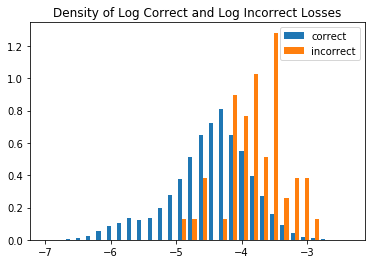


FPR = 5%
\begin{tabular}{llrrrr}
\toprule
{} &                                               File &  Detected &    Fooled &   Success &  Decreased\_Adv\_Effectiveness\_By \\
\midrule
0  &  logs\_mnist\_modcap\_adv\_00\_20200527\_23\_17\_55\_007... &  0.987896 &  0.026430 &  0.001222 &                        0.953782 \\
1  &  logs\_mnist\_modcap\_adv\_tnk\_20200528\_08\_08\_09\_26... &  0.359578 &  0.003554 &  0.001333 &                        0.625000 \\
2  &  logs\_mnist\_modcap\_adv\_ten\_20200528\_05\_44\_35\_25... &  0.356469 &  0.003665 &  0.001777 &                        0.515152 \\
3  &  logs\_mnist\_modcap\_adv\_tho\_20200528\_05\_58\_05\_46... &  0.359134 &  0.003554 &  0.001777 &                        0.500000 \\
4  &  logs\_mnist\_modcap\_adv\_50\_20200528\_04\_05\_33\_023... &  0.363021 &  0.004109 &  0.001999 &                        0.513514 \\
5  &  logs\_mnist\_modcap\_adv\_hun\_20200528\_05\_51\_02\_80... &  0.360355 &  0.005108 &  0.002443 &                        

In [11]:
# MNIST ModCap
patches_dir = "logs/mnist/new_recon_custom_weightreg_dropout/20191202_13:41:11:544060_/test"
regex = re.compile('\S*png_test.csv')
scale_out_of_ten = scale
visualize_patches_results(patches_dir, regex, scale_out_of_ten)

95th percentile of Correctly Classified Reconstruction Loss: 0.042774921400000006


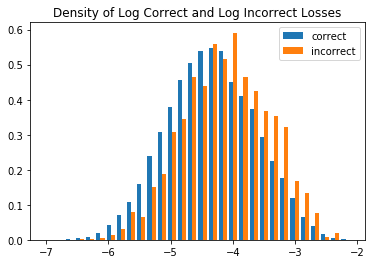


FPR = 5%
\begin{tabular}{llrrrr}
\toprule
{} &                                               File &  Detected &    Fooled &   Success &  Decreased\_Adv\_Effectiveness\_By \\
\midrule
0  &  logs\_svhn\_cnn\_adv\_tnk\_20200620\_09\_05\_43\_243190... &  0.079185 &  0.014906 &  0.013012 &                        0.127072 \\
1  &  logs\_svhn\_cnn\_adv\_35\_20200620\_08\_42\_31\_077073\_... &  0.236813 &  0.020136 &  0.014577 &                        0.276074 \\
2  &  logs\_svhn\_cnn\_adv\_50\_20200620\_08\_47\_39\_630417\_... &  0.242619 &  0.020877 &  0.016306 &                        0.218935 \\
3  &  logs\_svhn\_cnn\_adv\_tho\_20200620\_08\_59\_25\_150494... &  0.082438 &  0.018571 &  0.016348 &                        0.119734 \\
4  &  logs\_svhn\_cnn\_adv\_40\_20200620\_08\_46\_51\_778986\_... &  0.252954 &  0.021289 &  0.016636 &                        0.218569 \\
5  &  logs\_svhn\_cnn\_adv\_20\_20200620\_08\_37\_47\_014543\_... &  0.257031 &  0.022112 &  0.017089 &                    

In [12]:
# SVHN CNN
patches_dir = "logs/svhn/cnn_low_lr/20200609_10:15:57:439982_/test"
regex = re.compile('\S*png_test.csv')
scale_out_of_ten = scale
visualize_patches_results(patches_dir, regex, scale_out_of_ten)

95th percentile of Correctly Classified Reconstruction Loss: 0.029236219299999998


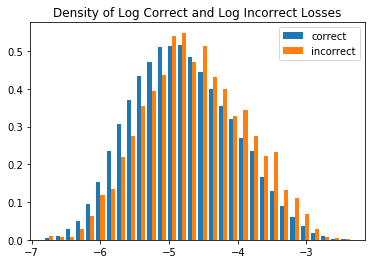


FPR = 5%
\begin{tabular}{llrrrr}
\toprule
{} &                                               File &  Detected &    Fooled &   Success &  Decreased\_Adv\_Effectiveness\_By \\
\midrule
0  &  logs\_svhn\_nomod\_adv\_tnk\_20200615\_09\_34\_34\_3957... &  0.066543 &  0.022483 &  0.021124 &                        0.060440 \\
1  &  logs\_svhn\_nomod\_adv\_tho\_20200615\_09\_34\_34\_3547... &  0.065761 &  0.023060 &  0.021618 &                        0.062500 \\
2  &  logs\_svhn\_nomod\_adv\_00\_20200615\_08\_46\_50\_48614... &  0.835289 &  0.147251 &  0.022895 &                        0.844519 \\
3  &  logs\_svhn\_nomod\_adv\_hun\_20200615\_09\_33\_35\_2607... &  0.066337 &  0.025530 &  0.023965 &                        0.061290 \\
4  &  logs\_svhn\_nomod\_adv\_05\_20200615\_08\_49\_37\_89872... &  0.854478 &  0.155528 &  0.025860 &                        0.833730 \\
5  &  logs\_svhn\_nomod\_adv\_10\_20200615\_08\_50\_06\_94313... &  0.767181 &  0.156805 &  0.044472 &                        

In [13]:
# SVHN NomodCap
patches_dir = "logs/svhn/nomod_cap/20200604_15:10:41:870680_/test"
regex = re.compile('\S*png_test.csv')
scale_out_of_ten = scale
visualize_patches_results(patches_dir, regex, scale_out_of_ten)

95th percentile of Correctly Classified Reconstruction Loss: 0.037018675


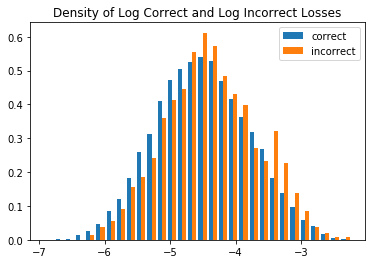


FPR = 5%
\begin{tabular}{llrrrr}
\toprule
{} &                                               File &  Detected &    Fooled &   Success &  Decreased\_Adv\_Effectiveness\_By \\
\midrule
0  &  logs\_svhn\_modcap\_adv\_tnk\_20200529\_21\_02\_15\_012... &  0.056283 &  0.004488 &  0.004076 &                        0.091743 \\
1  &  logs\_svhn\_modcap\_adv\_tho\_20200529\_20\_26\_38\_982... &  0.056777 &  0.005147 &  0.004694 &                        0.088000 \\
2  &  logs\_svhn\_modcap\_adv\_hun\_20200529\_19\_08\_42\_875... &  0.056448 &  0.005517 &  0.005147 &                        0.067164 \\
3  &  logs\_svhn\_modcap\_adv\_05\_20200529\_14\_28\_15\_4028... &  0.628376 &  0.167078 &  0.058753 &                        0.648349 \\
4  &  logs\_svhn\_modcap\_adv\_ten\_20200529\_18\_58\_35\_579... &  0.081316 &  0.063282 &  0.060647 &                        0.041640 \\
5  &  logs\_svhn\_modcap\_adv\_00\_20200529\_14\_25\_18\_5444... &  0.606678 &  0.161973 &  0.065217 &                        

In [14]:
# SVHN Modcap
patches_dir = "logs/svhn/single_pred_0_bg/20200220_17:42:42:547446_/test"
regex = re.compile('\S*png_test.csv')
scale_out_of_ten = scale
visualize_patches_results(patches_dir, regex, scale_out_of_ten)

95th percentile of Correctly Classified Reconstruction Loss: 0.058381715499999993


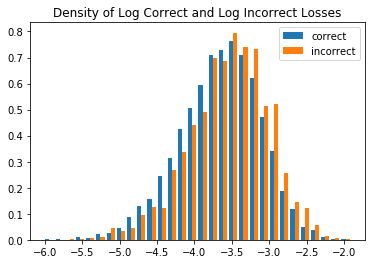


FPR = 5%
\begin{tabular}{llrrrr}
\toprule
{} &                                               File &  Detected &    Fooled &   Success &  Decreased\_Adv\_Effectiveness\_By \\
\midrule
0  &  logs\_cifar10\_cnn\_lr\_adv\_tnk\_20200618\_20\_36\_37\_... &  0.048911 &  0.021787 &  0.020787 &                        0.045918 \\
1  &  logs\_cifar10\_cnn\_lr\_adv\_05\_20200616\_13\_10\_42\_9... &  0.308359 &  0.304357 &  0.220542 &                        0.275383 \\
2  &  logs\_cifar10\_cnn\_lr\_adv\_00\_20200616\_07\_20\_23\_6... &  0.308582 &  0.307248 &  0.234549 &                        0.236614 \\
3  &  logs\_cifar10\_cnn\_lr\_adv\_20\_20200617\_15\_20\_25\_1... &  0.307248 &  0.350823 &  0.257225 &                        0.266793 \\
4  &  logs\_cifar10\_cnn\_lr\_adv\_45\_20200618\_07\_19\_25\_9... &  0.316696 &  0.393953 &  0.284349 &                        0.278217 \\
5  &  logs\_cifar10\_cnn\_lr\_adv\_40\_20200618\_06\_35\_35\_5... &  0.294131 &  0.386060 &  0.291018 &                  

In [15]:
# CIFAR10 CNN
patches_dir = "logs/cifar10/cnn_low_lr/20200507_14:21:23:956872_/test"
regex = re.compile('\S*lr_adv\S*png_test.csv')
scale_out_of_ten = scale
visualize_patches_results(patches_dir, regex, scale_out_of_ten)

95th percentile of Correctly Classified Reconstruction Loss: 0.05725838999999999


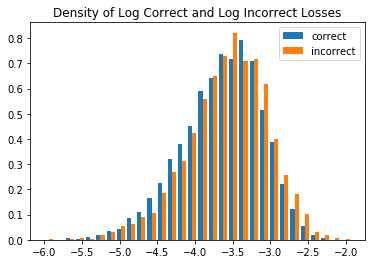


FPR = 5%
\begin{tabular}{llrrrr}
\toprule
{} &                                               File &  Detected &    Fooled &   Success &  Decreased\_Adv\_Effectiveness\_By \\
\midrule
0  &  logs\_cifar10\_nomod\_adv\_tnk\_20200615\_08\_45\_32\_1... &  0.041018 &  0.047577 &  0.044242 &                        0.070093 \\
1  &  logs\_cifar10\_nomod\_adv\_tho\_20200615\_08\_41\_52\_9... &  0.040907 &  0.049133 &  0.046354 &                        0.056561 \\
2  &  logs\_cifar10\_nomod\_adv\_hun\_20200615\_08\_40\_27\_2... &  0.040907 &  0.057803 &  0.055024 &                        0.048077 \\
3  &  logs\_cifar10\_nomod\_adv\_05\_20200613\_18\_35\_13\_37... &  0.569253 &  0.513673 &  0.229658 &                        0.552911 \\
4  &  logs\_cifar10\_nomod\_adv\_00\_20200613\_18\_35\_13\_37... &  0.554024 &  0.564695 &  0.270565 &                        0.520866 \\
5  &  logs\_cifar10\_nomod\_adv\_10\_20200613\_18\_35\_13\_37... &  0.542019 &  0.587594 &  0.282125 &                        

In [16]:
# CIFAR10 NomodCap
patches_dir = "logs/cifar10/nomod_cap/20200605_07:48:18:537613_/test"
regex = re.compile('\S*png_test.csv')
scale_out_of_ten = scale
visualize_patches_results(patches_dir, regex, scale_out_of_ten)

95th percentile of Correctly Classified Reconstruction Loss: 0.05629755


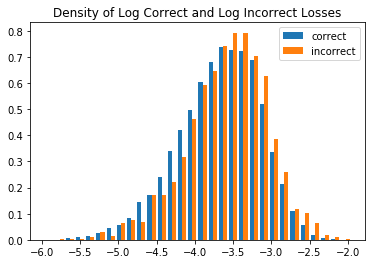


FPR = 5%
\begin{tabular}{llrrrr}
\toprule
{} &                                               File &  Detected &    Fooled &   Success &  Decreased\_Adv\_Effectiveness\_By \\
\midrule
0  &  logs\_cifar10\_modcap\_adv\_tnk\_20200604\_15\_10\_45\_... &  0.039222 &  0.017000 &  0.016000 &                        0.058824 \\
1  &  logs\_cifar10\_modcap\_adv\_tho\_20200604\_15\_10\_45\_... &  0.037333 &  0.019000 &  0.017667 &                        0.070175 \\
2  &  logs\_cifar10\_modcap\_adv\_hun\_20200604\_15\_10\_45\_... &  0.037889 &  0.024667 &  0.023444 &                        0.049550 \\
3  &  logs\_cifar10\_modcap\_adv\_45\_20200604\_15\_10\_45\_7... &  0.238000 &  0.238778 &  0.193667 &                        0.188925 \\
4  &  logs\_cifar10\_modcap\_adv\_35\_20200604\_15\_10\_45\_7... &  0.289667 &  0.248222 &  0.193667 &                        0.219785 \\
5  &  logs\_cifar10\_modcap\_adv\_40\_20200604\_15\_10\_45\_7... &  0.284889 &  0.262222 &  0.203333 &                        

In [17]:
# CIFAR10 Modcap
patches_dir = "logs/cifar10/bg_recon_0/20191024_14:00:15:440334_/test"
regex = re.compile('\S*png_test.csv')
scale_out_of_ten = scale
visualize_patches_results(patches_dir, regex, scale_out_of_ten)

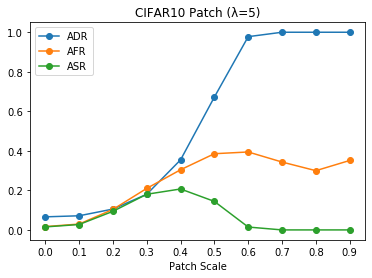

In [22]:
# cifar10 cnn
path = "logs/cifar10/cnn_low_lr/20200507_14:21:23:956872_/test/"
file = "logs_cifar10_cnn_lr_adv_05_20200616_13_10_42_930883__train_saved_patch_png_test.csv"
df = pd.read_csv(path + file)
display_scaled_patch_success_detection_rates(df, 0, 0.05629755, title="CIFAR10 Patch (λ=0.5)", pdfout="adaptive.pdf")

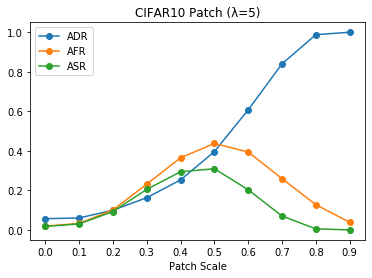

In [23]:
# cifar10 modcap
path = "logs/cifar10/bg_recon_0/20191024_14:00:15:440334_/test/"
file = "logs_cifar10_modcap_adv_50_20200604_15_10_45_702109__train_saved_patch_png_test.csv"
df = pd.read_csv(path + file)
display_scaled_patch_success_detection_rates(df, 0, 0.05629755, title="CIFAR10 Patch (λ=5)", pdfout="adaptive.pdf")

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import re
datasets = ["MNIST", "SVHN", "CIFAR10"]
architectures = ["CNN", "CapsNet", "Improved CapsNet"]

naive_mnist = ["logs/mnist/cnn_adv_00/20200527_16:34:47:996346_/train/saved_patch.png", "logs/mnist/nomodcap_adv_00/20200613_17:57:35:190094_/train/saved_patch.png", "logs/mnist/modcap_adv_00/20200527_23:17:55:007849_/train/saved_patch.png"]
naive_svhn = ["logs/svhn/cnn_adv_00/20200620_06:15:15:404306_/train/saved_patch.png", "logs/svhn/nomod_adv_00/20200615_08:46:50:486140_/train/saved_patch.png", "logs/svhn/modcap_adv_00/20200529_14:25:18:544445_/train/saved_patch.png"]
naive_cifar10 = ["logs/cifar10/cnn_lr_adv_00/20200616_07:20:23:625917_/train/saved_patch.png", "logs/cifar10/nomod_adv_00/20200613_18:35:13:374847_/train/saved_patch.png", "logs/cifar10/modcap_adv_00/20200604_15:10:45:701524_/train/saved_patch.png"]
naive_patches_matrix = [naive_mnist, naive_svhn, naive_cifar10]
adaptive_mnist = ["logs/mnist/cnn_adv_tnk/20200527_23:12:21:154178_/train/saved_patch.png", "logs/mnist/nomodcap_adv_10/20200613_17:57:35:183119_/train/saved_patch.png", "logs/mnist/modcap_adv_10/20200527_23:21:15:699840_/train/saved_patch.png"]
adaptive_svhn = ["logs/svhn/cnn_adv_05/20200620_07:34:41:398248_/train/saved_patch.png", "logs/svhn/nomod_adv_25/20200615_08:57:32:986118_/train/saved_patch.png", "logs/svhn/modcap_adv_50/20200529_18:50:56:538576_/train/saved_patch.png"]
adaptive_cifar10 = ["logs/cifar10/cnn_lr_adv_hun/20200618_18:35:41:992149_/train/saved_patch.png", "logs/cifar10/nomod_adv_ten/20200615_08:40:14:844708_/train/saved_patch.png", "logs/cifar10/modcap_adv_50/20200604_15:10:45:702109_/train/saved_patch.png"]
adaptive_patches_matrix = [adaptive_mnist, adaptive_svhn, adaptive_cifar10]

mnist_archs = ["logs/mnist/cnn_low_lr/20200507_14:21:23:955910_/test", "logs/mnist/nomod_cap/20200605_03:00:14:427684_/test", "logs/mnist/new_recon_custom_weightreg_dropout/20191202_13:41:11:544060_/test"]
svhn_archs = ["logs/svhn/cnn_low_lr/20200609_10:15:57:439982_/test", "logs/svhn/nomod_cap/20200604_15:10:41:870680_/test", "logs/svhn/single_pred_0_bg/20200220_17:42:42:547446_/test"]
cifar10_archs = ["logs/cifar10/cnn_low_lr/20200507_14:21:23:956872_/test", "logs/cifar10/nomod_cap/20200605_07:48:18:537613_/test", "logs/cifar10/bg_recon_0/20191024_14:00:15:440334_/test"]
architectures_by_dataset = [mnist_archs, svhn_archs, cifar10_archs]

def plot_patches_matrix(patches_matrix):
    fig, axs = plt.subplots(len(datasets), len(architectures))
    for d, dataset in enumerate(datasets):
        axs[d, 0].set(ylabel=dataset)
        for a, architecture in enumerate(architectures):
            patch = patches_matrix[d][a]
            axs[d, a].imshow(mpimg.imread(patches_matrix[d][a]))
    for a, architecture in enumerate(architectures):
        axs[0, a].set_title(architecture)

def plot_statistics_matrix(patches_matrix, architecture_matrix):
    def set_size(w,h, ax=None):
        """ w, h: width, height in inches """
        if not ax: ax=plt.gca()
        l = ax.figure.subplotpars.left
        r = ax.figure.subplotpars.right
        t = ax.figure.subplotpars.top
        b = ax.figure.subplotpars.bottom
        figw = float(w)/(r-l)
        figh = float(h)/(t-b)
        ax.figure.set_size_inches(figw, figh)
    fig, axs = plt.subplots(len(datasets), len(architectures))
    for d, dataset in enumerate(datasets):
        axs[d, 0].set(ylabel=dataset)
        for a, architecture in enumerate(architectures):
            p = axs[d, a]
            patch = patches_matrix[d][a]
            architecture = architecture_matrix[d][a]
            filename = re.sub('[^\w\-_]', '_', patch) + "_" + "test" + ".csv"
            csv_path = os.path.join(architecture, filename)
            df = pd.read_csv(csv_path)
            test = df[df['scales'] == 0]
            correct_losses, incorrect_losses = correct_incorrect_losses(test)
            critical_95 = np.percentile(correct_losses, 95)
            fooled_rates, detection_rates, success_rates = rates_by_scales(df, 0, critical_95)
            scales = fooled_rates.index
            p.plot(scales, detection_rates, '-o', label="ADR")
            p.plot(scales, fooled_rates, '-o', label="AFR")
            p.plot(scales, success_rates, '-o', label="ASR")
            p.set_xticks(np.arange(0, 1, 0.2))
    for a, architecture in enumerate(architectures):
        axs[0, a].set_title(architecture)
    axs[0, 0].legend(loc='upper left')
    set_size(6,6)

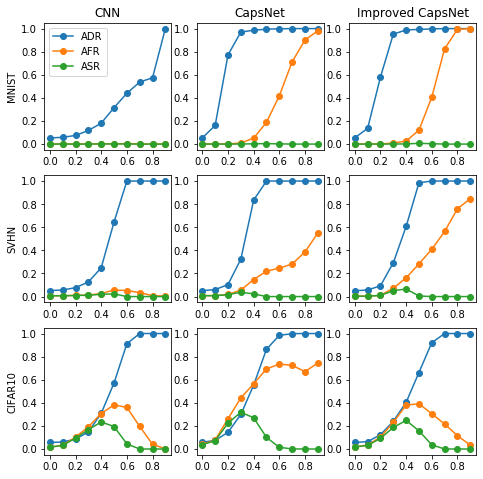

In [60]:
plot_statistics_matrix(naive_patches_matrix, architectures_by_dataset)

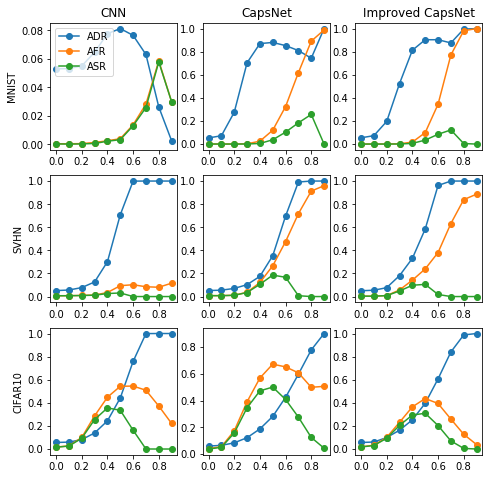

In [61]:
plot_statistics_matrix(adaptive_patches_matrix, architectures_by_dataset)

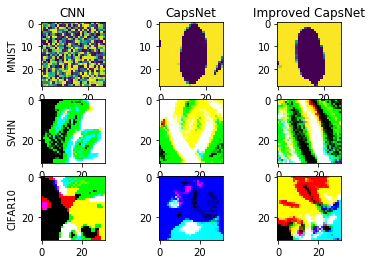

In [9]:
plot_patches_matrix(naive_patches_matrix)

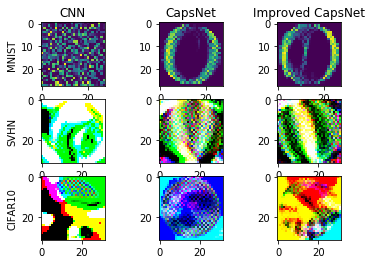

In [12]:
plot_patches_matrix(adaptive_patches_matrix)

In [ ]:
def plot_patches_matrix(patches_matrix):
    fig, axs = plt.subplots(len(datasets), len(architectures))
    for d, dataset in enumerate(datasets):
        axs[d, 0].set(ylabel=dataset)
        for a, architecture in enumerate(architectures):
            patch = patches_matrix[d][a]
            axs[d, a].imshow(mpimg.imread(patches_matrix[d][a]))
    for a, architecture in enumerate(architectures):
        axs[0, a].set_title(architecture)